In [8]:
import re
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
from wordfreq import top_n_list, word_frequency

from wiki_controller import WikiController

In [9]:
def get_topk_words(language):
    return top_n_list(language, 1000)

In [10]:
controller = WikiController("https://bulbapedia.bulbagarden.net/wiki")

def get_wiki_counts(phrase):
    controller.scrapper.scrape(phrase=phrase)
    text = controller.scrapper.get_words().lower()
    words = re.findall(r"\b[a-z]+(?:'[a-z]+)?\b", text) 
    return Counter(words)


long_wiki_phrase = "History of Pokémon"
long_wiki_counts = get_wiki_counts(long_wiki_phrase)

bad_wiki_phrase = "List of Japanese Pokémon names" 
bad_wiki_counts = get_wiki_counts(bad_wiki_phrase)

eng_lang_top = get_topk_words("en")
pl_lang_top = get_topk_words("pl")
esp_lang_top = get_topk_words("es")

In [11]:
def lang_confidence_score(word_counts, top_k_language):
    lang_set = {word for word in top_k_language}
    
    total_tokens = sum(word_counts.values())    
    matched_tokens = 0
    
    for word, count in word_counts.items():
        if word in lang_set:
            matched_tokens += count
            
    return matched_tokens / total_tokens

In [12]:
def get_language_counts(text):
    words = re.findall(r"\b[a-z]+(?:'[a-z]+)?\b", text.lower()) 
    return Counter(words)

with open("text_files/kubus_puchatek_EN.txt", "r") as f:
    en_text = f.read()

with open("text_files/kubus_puchatek_PL.txt", "r") as f:
    pl_text = f.read()

with open("text_files/Fingir_y_amar.txt", "r") as f:
    es_text = f.read()

en_text_count = get_language_counts(en_text)
pl_text_count = get_language_counts(pl_text)
es_text_count = get_language_counts(es_text)

In [13]:
all_texts = {
    "Wiki Long": long_wiki_counts,
    "Wiki Bad": bad_wiki_counts,
    "Text en": en_text_count,
    "Text pl": pl_text_count,
    "Text es": es_text_count
}

languages_data = {
    "en": eng_lang_top,
    "pl": pl_lang_top,
    "es": esp_lang_top
}

k_values = [3, 10, 100, 1000]
results = []

for k in k_values:
    for text_name, counts in all_texts.items():
        for lang_name, lang_freqs in languages_data.items():
            
            top_k_freqs = lang_freqs[:k]
            
            score = lang_confidence_score(counts, top_k_freqs)
            
            results.append({
                "k": k,
                "Text": text_name,
                "Language": lang_name,
                "Score": score
            })

df_results = pd.DataFrame(results)
print(df_results)

       k       Text Language     Score
0      3  Wiki Long       en  0.133255
1      3  Wiki Long       pl  0.001177
2      3  Wiki Long       es  0.000000
3      3   Wiki Bad       en  0.011147
4      3   Wiki Bad       pl  0.002447
5      3   Wiki Bad       es  0.000272
6      3    Text en       en  0.106249
7      3    Text en       pl  0.018873
8      3    Text en       es  0.002237
9      3    Text pl       en  0.032562
10     3    Text pl       pl  0.123965
11     3    Text pl       es  0.005427
12     3    Text es       en  0.000000
13     3    Text es       pl  0.000815
14     3    Text es       es  0.149959
15    10  Wiki Long       en  0.235917
16    10  Wiki Long       pl  0.023386
17    10  Wiki Long       es  0.024710
18    10   Wiki Bad       en  0.028548
19    10   Wiki Bad       pl  0.005438
20    10   Wiki Bad       es  0.002719
21    10    Text en       en  0.214455
22    10    Text en       pl  0.047253
23    10    Text en       es  0.033832
24    10    Text pl      

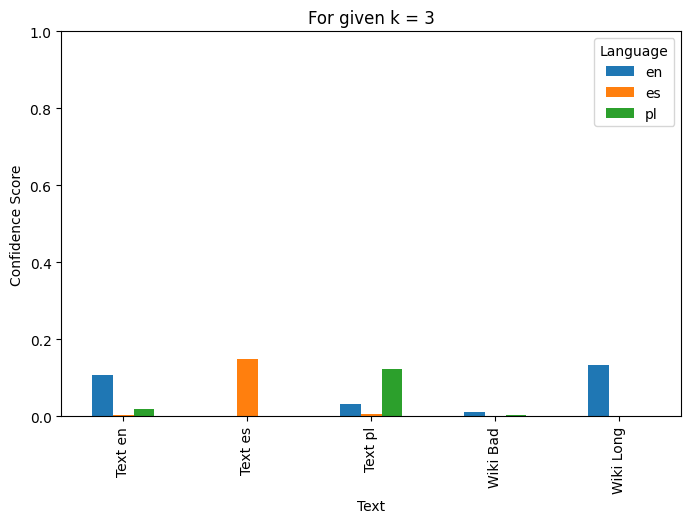

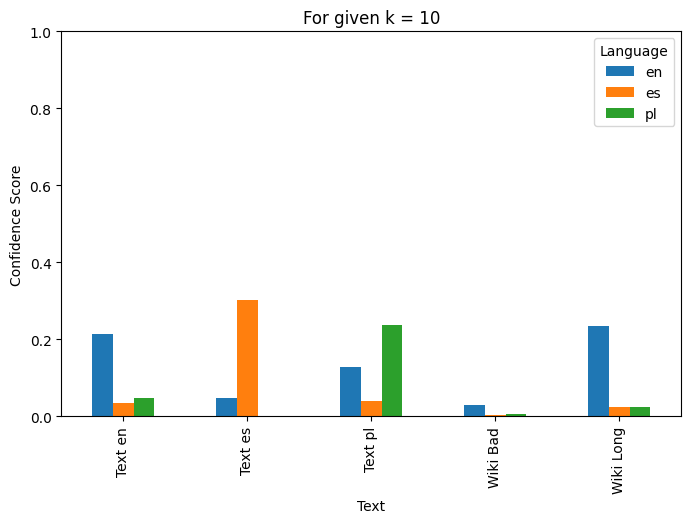

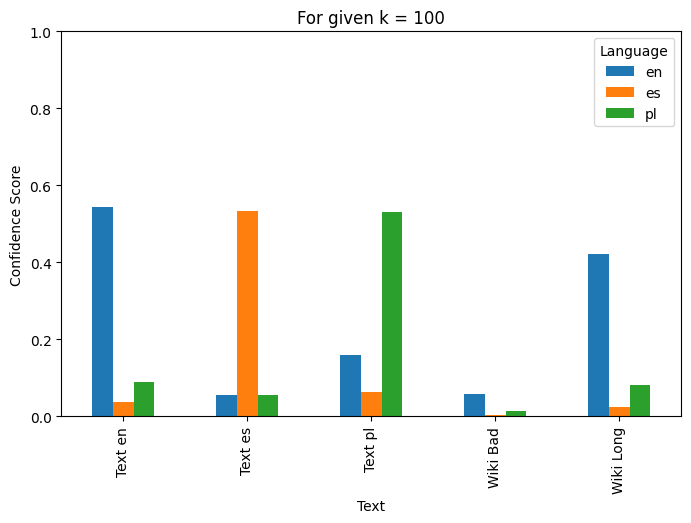

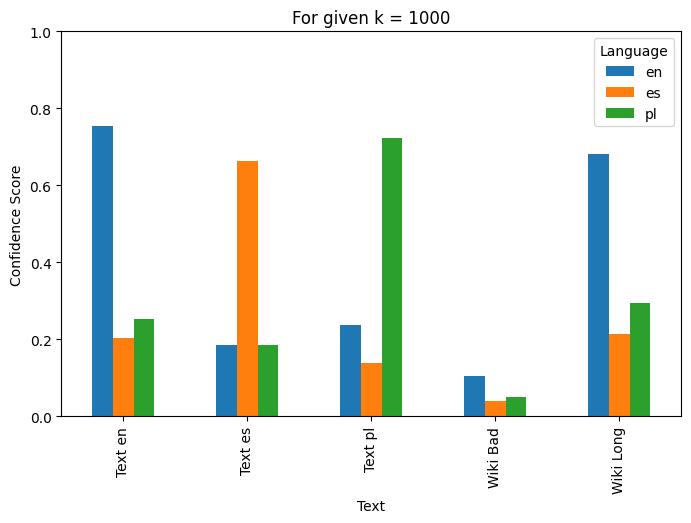

In [14]:
for k in k_values:
    data_k = df_results[df_results['k'] == k]
    
    pivot_data = data_k.pivot(index='Text', columns='Language', values='Score')
    
    pivot_data.plot(kind='bar', figsize=(8, 5))
    
    plt.title(f"For given k = {k}")
    plt.ylabel("Confidence Score")
    plt.ylim(0, 1)
    plt.show()

# Analiza

### Czy dobór języków miał duże znaczenie?
Zdecydowanie tak. Język hiszpański ma mało wspólnego z angielskim oraz polskim (różne alfabety), więc listy najpopularniejszych słów mało się pokrywają. Mimo to widać, że język angielski jest bardzie podobny do polskiego niż do hiszpańskiego.

### Czy po wartościach `language_words_with_frequency` dla danych i najczęstszych słowach z języka danych widać, że w wybranym języku słowa często są odmieniane?
Widać, aczykowlwiek nieznacznie. Można to zaobserwować na początku, gdzie język hiszpański miał znacząco wyższe dopasowanie od języka angielskiego. Gdy zakres słów się poszerzył, angielski osiagnął najwyższy wynik. Niestety nie widać tej zależności przy porównywaniu języka angielskiego z polskim, ale być może wynika to z specyfikacji tekstów, które wybrałem.

### Czy trudne było znalezienie takiego artykułu, dla którego wynik `language_words_with_frequency` jest jak najmniejszy w języku wiki? Czy to specyfika tego wiki?
Nie było to trudne. Każdy Pokemon ma japońską nazwę, więc można było się domyśleć, że istnieje strona poświęcona wszystkim japońskim nazwom Pokemonów. Język japoński nie ma nic wspólnego z językiem angielskim, stąd taki niski wynik.